In [144]:
pip install openslide-python

Note: you may need to restart the kernel to use updated packages.


In [145]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [146]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [147]:

import openslide, numpy as np
import cv2
from cv2 import filter2D


In [148]:
tcga_slide = '/Users/m294161/yottixel/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F.svs'
slide = openslide.open_slide(tcga_slide)

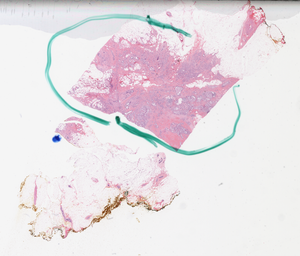

In [149]:
slide.get_thumbnail((300, 300))

In [150]:
magnification = slide.properties['openslide.mpp-x']

In [151]:
print(f"Magnification: {magnification}x")

Magnification: 0.25209999999999999x


In [152]:
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps
    
    OD = -np.log(X / 1.0)
    D  = np.mean(OD,3)
    D[np.where(D==0.0)] = eps
    
    cx = OD[:,:,:,0] / (D) - 1.0
    cy = (OD[:,:,:,1]-OD[:,:,:,2]) / (np.sqrt(3.0)*D)
    
    D = np.expand_dims(D,3)
    cx = np.expand_dims(cx,3)
    cy = np.expand_dims(cy,3)
            
    X_HSD = np.concatenate((D,cx,cy),3)
    return X_HSD


def clean_thumbnail(thumbnail):
    thumbnail_arr = np.asarray(thumbnail)
    
    # writable thumbnail
    wthumbnail = np.zeros_like(thumbnail_arr)
    wthumbnail[:, :, :] = thumbnail_arr[:, :, :]

    # Remove pen marking here
    # We are skipping this
    
    # This  section sets regoins with white spectrum as the backgroud regoin
    thumbnail_std = np.std(wthumbnail, axis=2)
    wthumbnail[thumbnail_std<5] = (np.ones((1,3), dtype="uint8")*255)
    thumbnail_HSD = RGB2HSD( np.array([wthumbnail.astype('float32')/255.]) )[0]
    kernel = np.ones((30,30),np.float32)/900
    thumbnail_HSD_mean = cv2.filter2D(thumbnail_HSD[:,:,2],-1,kernel)
    wthumbnail[thumbnail_HSD_mean<0.05] = (np.ones((1,3),dtype="uint8")*255)
    return wthumbnail

(-0.5, 499.5, 426.5, -0.5)

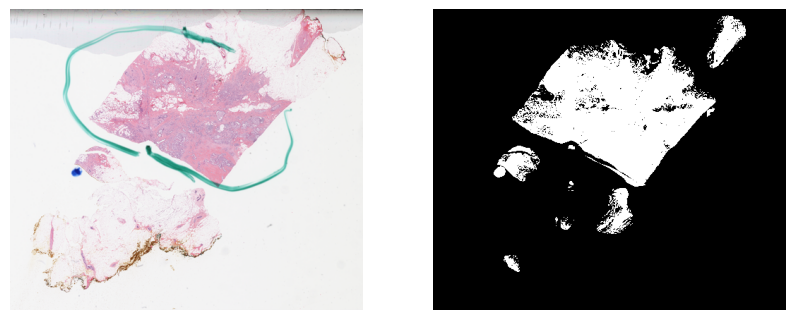

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

thumbnail = slide.get_thumbnail((500, 500))
cthumbnail = clean_thumbnail(thumbnail)
tissue_mask = (cthumbnail.mean(axis=2) != 255)*1.

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tissue_mask, cmap='Greys_r')
plt.axis('off')

In [154]:
objective_power = int(slide.properties['openslide.objective-power'])
print(objective_power)

40


In [155]:
w, h = slide.dimensions

# at 20x its 1000x1000
patch_size = (objective_power/20.)*1000
patch_size

2000.0

In [156]:
mask_hratio = (tissue_mask.shape[0]/h)*patch_size
mask_wratio = (tissue_mask.shape[1]/w)*patch_size

# iterating over patches
patches = []

for i, hi in enumerate(range(0, h, int(patch_size) )):
    
    _patches = []
    for j, wi in enumerate(range(0, w, int(patch_size) )):
        
        # check if patch contains 70% tissue area
        mi = int(i*mask_hratio)
        mj = int(j*mask_wratio)
        
        patch_mask = tissue_mask[mi:mi+int(mask_hratio), mj:mj+int(mask_wratio)]
        
        tissue_coverage = np.count_nonzero(patch_mask)/patch_mask.size
        
        _patches.append({'loc': [i, j], 'wsi_loc': [int(hi), int(wi)], 'tissue_coverage': tissue_coverage})
        
    patches.append(_patches)

In [157]:
patches

[[{'loc': [0, 0], 'wsi_loc': [0, 0], 'tissue_coverage': 0.0},
  {'loc': [0, 1], 'wsi_loc': [0, 2000], 'tissue_coverage': 0.0},
  {'loc': [0, 2], 'wsi_loc': [0, 4000], 'tissue_coverage': 0.0},
  {'loc': [0, 3], 'wsi_loc': [0, 6000], 'tissue_coverage': 0.0},
  {'loc': [0, 4], 'wsi_loc': [0, 8000], 'tissue_coverage': 0.0},
  {'loc': [0, 5], 'wsi_loc': [0, 10000], 'tissue_coverage': 0.0},
  {'loc': [0, 6], 'wsi_loc': [0, 12000], 'tissue_coverage': 0.0},
  {'loc': [0, 7], 'wsi_loc': [0, 14000], 'tissue_coverage': 0.0},
  {'loc': [0, 8], 'wsi_loc': [0, 16000], 'tissue_coverage': 0.0},
  {'loc': [0, 9], 'wsi_loc': [0, 18000], 'tissue_coverage': 0.0},
  {'loc': [0, 10], 'wsi_loc': [0, 20000], 'tissue_coverage': 0.0},
  {'loc': [0, 11], 'wsi_loc': [0, 22000], 'tissue_coverage': 0.0},
  {'loc': [0, 12], 'wsi_loc': [0, 24000], 'tissue_coverage': 0.0},
  {'loc': [0, 13], 'wsi_loc': [0, 26000], 'tissue_coverage': 0.0},
  {'loc': [0, 14], 'wsi_loc': [0, 28000], 'tissue_coverage': 0.0},
  {'loc': [0,

In [158]:
import tqdm

# for patch to be considered it should have this much tissue area
tissue_threshold = 0.7

flat_patches = np.ravel(patches)
for patch in tqdm.tqdm(flat_patches):
    
    # ignore patches with less tissue coverage
    if patch['tissue_coverage'] < tissue_threshold:
        continue
    
    # this loc is at the objective power
    h, w = patch['wsi_loc']
    
    # we will go obe level lower, i.e. (objective power / 4)
    # we still need patches at 5x of size 250x250
    # this logic can be modified and may not work properly for images of lower objective power < 20 or greater than 40
    patch_size_5x = int(((objective_power / 4)/5)*250.)
    
    patch_region = slide.read_region((w, h), 1, (patch_size_5x, patch_size_5x)).convert('RGB')
    
    if patch_region.size[0] != 250:
        patch_region = patch_region.resize((250, 250))
    
    histogram = (np.array(patch_region)/255.).reshape((250*250, 3)).mean(axis=0)
    patch['rgb_histogram'] = histogram    

100%|██████████| 1968/1968 [00:04<00:00, 469.67it/s]


In [159]:
from sklearn.cluster import KMeans
selected_patches_flags = [patch['tissue_coverage'] >= tissue_threshold for patch in flat_patches]
selected_patches = flat_patches[selected_patches_flags]

kmeans_clusters = 47
kmeans = KMeans(n_clusters = kmeans_clusters)
features = np.array([entry['rgb_histogram'] for entry in selected_patches])

kmeans.fit(features)

/Users/M295788/anaconda3/envs/my_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=47)

In [160]:
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap('hsv', kmeans_clusters)

/var/folders/9j/4psnxlf94p5cxrj9cnxpzmbc0000gr/T/ipykernel_23847/2691410323.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', kmeans_clusters)


(-0.5, 47.5, 40.5, -0.5)

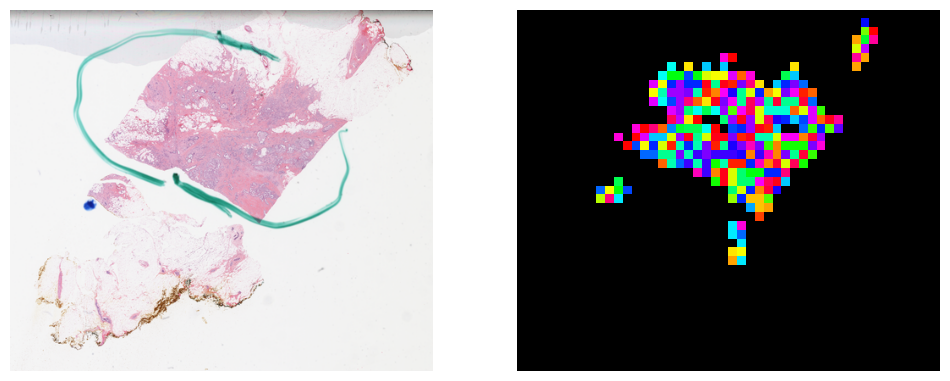

In [161]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))


for patch, label in zip(selected_patches, kmeans.labels_):
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(label)[:3]
    patch['cluster_lbl'] = label

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [162]:
# Another hyperparameter of Yottixel
# Yottixel has been tested with 5, 10, and 15 with 15 performing most optimally
percentage_selected = 15

mosaic = []

for i in range(kmeans_clusters):
    cluster_patches = selected_patches[kmeans.labels_ == i]
    n_selected = max(1, int(len(cluster_patches)*percentage_selected/100.))
    
    km = KMeans(n_clusters=n_selected)
    loc_features = [patch['wsi_loc'] for patch in cluster_patches]
    ds = km.fit_transform(loc_features)
    
    c_selected_idx = []
    for idx in range(n_selected):
        sorted_idx = np.argsort(ds[:, idx])
        
        for sidx in sorted_idx:
            if sidx not in c_selected_idx:
                c_selected_idx.append(sidx)
                mosaic.append(cluster_patches[sidx])
                break

/Users/M295788/anaconda3/envs/my_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/M295788/anaconda3/envs/my_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/M295788/anaconda3/envs/my_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/M295788/anaconda3/envs/my_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

(-0.5, 47.5, 40.5, -0.5)

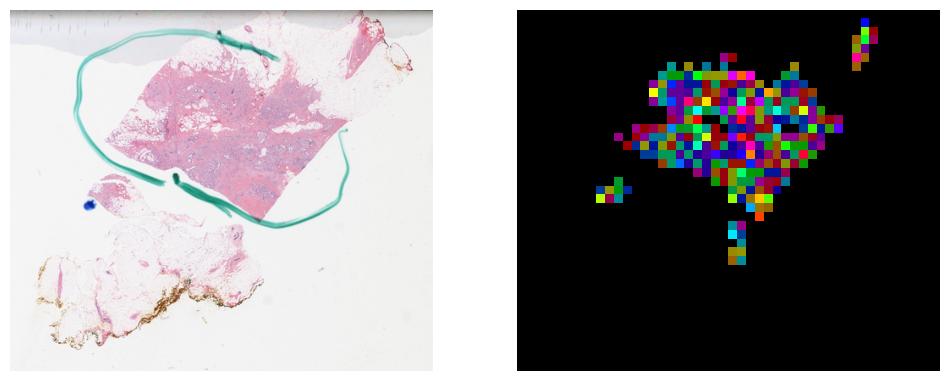

In [163]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))

for patch in selected_patches:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = np.array(cmap(patch['cluster_lbl'])[:3])*0.6
for patch in mosaic:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(patch['cluster_lbl'])[:3]
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [164]:
import tensorflow as tf

def preprocessing_fn(inp, sz=(1000, 1000)):

    out = tf.cast(inp, 'float') / 255.
    
    out = tf.cond(tf.equal(tf.shape(inp)[1], sz[0]), 
                lambda: out, lambda: tf.image.resize(out, sz))
    
    mean = tf.reshape((0.485, 0.456, 0.406), [1, 1, 1, 3])
    std = tf.reshape((0.229, 0.224, 0.225), [1, 1, 1, 3])
    
    out = out - mean
    out = out / std
    
    return out


def get_dn121_model():
    model = tf.keras.applications.densenet.DenseNet121(input_shape=(1000, 1000, 3),\
                                                       include_top=False,\
                                                       pooling='avg')
    
    seq_model = tf.keras.models.Sequential([tf.keras.layers.Lambda(preprocessing_fn,\
                                                   input_shape=(None, None, 3),\
                                                   dtype=tf.uint8)])
    seq_model.add(model)
    return seq_model


model = get_dn121_model()

In [165]:
patch_queue = []
feature_queue = []
batch_size = 20

for patch in tqdm.tqdm(mosaic):
    
    # this loc is at the objective power
    h, w = patch['wsi_loc']
    
    patch_size_20x = int((objective_power/20.)*1000)
    patch_region = slide.read_region((w, h), 0, (patch_size_20x, patch_size_20x)).convert('RGB')
    
    patch_queue.append(np.array(patch_region))
    if len(patch_queue) == batch_size:
        feature_queue.extend(model.predict( np.array(patch_queue) ))
        patch_queue = []
        
if len(patch_queue) != 0:
    padded_arr = np.zeros((batch_size, patch_size_20x, patch_size_20x, 3))
    padded_arr[:len(patch_queue), :, :, :] = np.array(patch_queue)
    feature_queue.extend(model.predict( padded_arr )[:len(patch_queue)])

  0%|          | 0/49 [00:00<?, ?it/s]

 37%|███▋      | 18/49 [00:01<00:02, 13.80it/s]

1/1 [==============================] - 13s 13s/step


 78%|███████▊  | 38/49 [00:16<00:01,  6.38it/s]

1/1 [==============================] - 12s 12s/step


100%|██████████| 49/49 [00:29<00:00,  1.66it/s]


1/1 [==============================] - 12s 12s/step


In [166]:
features=np.array(feature_queue)
features.shape

(49, 1024)

In [167]:
features 

array([[1.7257528e-04, 3.2597976e-03, 1.9272963e-03, ..., 1.2827039e+00,
        3.1653494e-01, 2.6080751e-01],
       [3.9801316e-04, 3.1932774e-03, 1.9945074e-03, ..., 8.0579329e-01,
        1.6458991e-01, 3.3613944e-01],
       [3.4093822e-04, 2.5910486e-03, 2.5580616e-03, ..., 6.5538347e-01,
        7.1130675e-01, 1.4815779e-01],
       ...,
       [3.5217340e-04, 4.2168410e-03, 1.7582971e-03, ..., 1.3484756e+00,
        1.2439098e-01, 1.4891998e-01],
       [3.7660950e-04, 5.9796115e-03, 1.1843255e-03, ..., 1.7751745e+00,
        2.5407445e-01, 3.0729565e-01],
       [2.9698669e-04, 3.8147187e-03, 1.7660636e-03, ..., 7.8665036e-01,
        1.6338716e-01, 3.3446759e-01]], dtype=float32)

In [168]:
# row_of_zeros = np.zeros((1, 1024))

# # Concatenate the row of zeros at the end of the existing array
# existing_array = np.concatenate((features, row_of_zeros), axis=0)
# print(existing_array.shape)

In [169]:
import numpy as np
from queue import Queue

# Define the dimensions
num_instances = 49
num_features = 1024
instance_dim = 32

random_features_queue=Queue()

# Enqueue features into the queue (example)
for _ in range(features.shape[0]):
    new_features = np.random.rand(num_features)
    random_features_queue.put(new_features)

# Create a bag of instances
bag_of_instances = np.zeros((features.shape[0], instance_dim, instance_dim))

# Dequeue features and reshape into instances
for i in range(num_instances):
    featuresusk = random_features_queue.get()
    instance = featuresusk.reshape((instance_dim, instance_dim))
    bag_of_instances[i] = instance

# Verify the shape of the bag of instances
print(bag_of_instances.shape)

(49, 32, 32)


In [170]:

grid = bag_of_instances.reshape((7, 7, 32, 32))
H_stacked = [np.hstack(row) for row in grid]
final_array = np.vstack(H_stacked)
print(final_array.shape)

(224, 224)


In [172]:
print(final_array)

[[0.16233108 0.15727723 0.17434196 ... 0.1399282  0.68033418 0.4854724 ]
 [0.54457299 0.88850358 0.31773954 ... 0.9355352  0.07632217 0.89658108]
 [0.93204125 0.58539983 0.9188103  ... 0.97877415 0.99347648 0.78828053]
 ...
 [0.98957285 0.62343134 0.86659037 ... 0.13120699 0.59892223 0.12429816]
 [0.44855937 0.09986165 0.98050165 ... 0.32137392 0.35885435 0.15053385]
 [0.85045633 0.89374955 0.77051566 ... 0.80533622 0.57783257 0.8064798 ]]


In [174]:
#converting into the specific format

data_dict = {'feature': final_array}

# Save the dictionary to a numpy file
np.save('test_1.npy', data_dict)